QuickStart: Compare runs, choose a model, and deploy it to a Rest Api

In this quickstart, we will:
1. Run a hyperparameter sweep on a training script

2. compare the result of the runs in the mlflow ui

3. choose the best run and register it as a model

4. Deploy the model to a Rest Api

5. Build a container image suitable for deployment to a cloud platform 

In [1]:
import keras
import numpy as np
import pandas as pd
from hyperopt import STATUS_OK,Trials,fmin,hp,tpe
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow
from mlflow.models import infer_signature

In [2]:
##load the dataset

data=pd.read_csv(
    "https://raw.githubusercontent.com/mlflow/mlflow/master/tests/datasets/winequality-white.csv",sep=";")

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
##split the data into training, validation and test sets

train,test=train_test_split(data,test_size=0.25,random_state=42)
train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2835,6.3,0.25,0.22,3.30,0.048,41.0,161.0,0.99256,3.16,0.50,10.5,6
1157,7.8,0.30,0.29,16.85,0.054,23.0,135.0,0.99980,3.16,0.38,9.0,6
744,7.4,0.38,0.27,7.50,0.041,24.0,160.0,0.99535,3.17,0.43,10.0,5
1448,7.4,0.16,0.49,1.20,0.055,18.0,150.0,0.99170,3.23,0.47,11.2,6
3338,7.2,0.27,0.28,15.20,0.046,6.0,41.0,0.99665,3.17,0.39,10.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4426,6.2,0.21,0.52,6.50,0.047,28.0,123.0,0.99418,3.22,0.49,9.9,6
466,7.0,0.14,0.32,9.00,0.039,54.0,141.0,0.99560,3.22,0.43,9.4,6
3092,7.6,0.27,0.52,3.20,0.043,28.0,152.0,0.99129,3.02,0.53,11.4,6
3772,6.3,0.24,0.29,13.70,0.035,53.0,134.0,0.99567,3.17,0.38,10.6,6


In [4]:
train_x=train.drop(['quality'],axis=1).values
train_y=train[["quality"]].values.ravel()

##test dataset 
test_x=test.drop(['quality'],axis=1).values
test_y=test[["quality"]].values.ravel()

#splitting this train into train and validation. 
train_x,valid_x,train_y,valid_y=train_test_split(train_x,train_y,test_size=0.20,random_state=42)

signature=infer_signature(train_x,train_y)

In [ ]:
##ANN model

def train_model(params, epochs,train_x,train_y,valid_x,valid_y,test_x,test_y):

    #

    #Normalise the data
    mean=np.mean(train_x,axis=0)
    var=np.var(train_x,axis=0)
    
    ##Define model architecture
    model=keras.Sequential(
        [
            keras.Input([train_x.shape[1]]),
            keras.layers.Normalization(mean=mean,variance=var),
            keras.layers.Dense(64,activation="relu"),
            keras.layers.Dense(1)

        ]
    )

    #compile the model
    model.compile(optimizer=keras.optimizers.SGD(
        learning_rate=params['lr'],momentum=params['momentum']
    ),
    loss="mean_squared_error",
    metrics=[keras.metrics.RootMeanSquaredError()])

    ##Train the ANN model with lr and momentum params with MLflow tracking

    with mlflow.start_run(nested=True):
        #fit the model 
        model.fit(train_x,train_y,validation_data=(valid_x,valid_y),
        epochs=epochs,
        batch_size=64)

        #Evaluate the model
        eval_result=model.evaluate(valid_x,valid_y,batch_size=64)
        
        eval_rmse=eval_result[1]

        ##log the parameters and results
        mlflow.log_params(params)
        mlflow.log_metric("eval_rmse",eval_rmse)

        ##log the model
        mlflow.tensorflow.log_model(model,"model",signature=signature)

        return {'loss':eval_rmse,"status":STATUS_OK,"model":model}



In [14]:
def objective(params):
    #Mlflow will track the parameters and result for each run 

    result=train_model(
        params,
        epochs=3,
        train_x=train_x,
        train_y=train_y,
        valid_x=valid_x,
        valid_y=valid_y,
        test_x=test_x,
        test_y=test_y
    )

    return result

In [15]:
space={
    "lr":hp.loguniform("lr",np.log(1e-5),np.log(1e-1)),
    "momentum":hp.uniform('momentum',0.0,1.0)
}

In [ ]:
mlflow.set_experiment("/wine-quality")
with mlflow.start_run():
    #conduct the hyperparameter search using hyperopt
    trials=Trials()
    #fmin() runs the hyperparameter search using:
    best=fmin(
        fn=objective,#function that returns loss + model
        space=space, # the hyperparameter search space
        algo=tpe.suggest, #Tree-structured Parzen Estimator (a Bayesian optimization strategy)
        max_evals=4, #runs 4 trial experiments
        trials=trials #object that stores the result of each trial
    )
 
    #fetch the details of the best run
    best_run=sorted(trials.results,key=lambda x:x["loss"])[0]

    #log the best parameters,loss, model
    mlflow.log_params(best)
    mlflow.log_metric("eval_rmse",best_run["loss"])
    mlflow.tensorflow.log_model(best_run['model'],"model",signature=signature)

    #print out the best parameters and corresponding loss
    print(f"best parameters:{best}")
    print(f"best eval rmse:{best_run['loss']}")

Epoch 1/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 30.4942 - root_mean_squared_error: 5.5222
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.7176 - root_mean_squared_error: 5.3585 - val_loss: 25.5957 - val_root_mean_squared_error: 5.0592

Epoch 2/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 27.0667 - root_mean_squared_error: 5.2026
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 24.8883 - root_mean_squared_error: 4.9885 - val_loss: 22.0848 - val_root_mean_squared_error: 4.6994

Epoch 3/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 25.0721 - root_mean_squared_error: 5.0072
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 21.7322 - root_mean_squared_error: 4.6610 - val_loss: 19.0019 - val_root_mean_squared_error: 4.3591

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18.7280 - root_mean_squared_error: 4.3276
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s

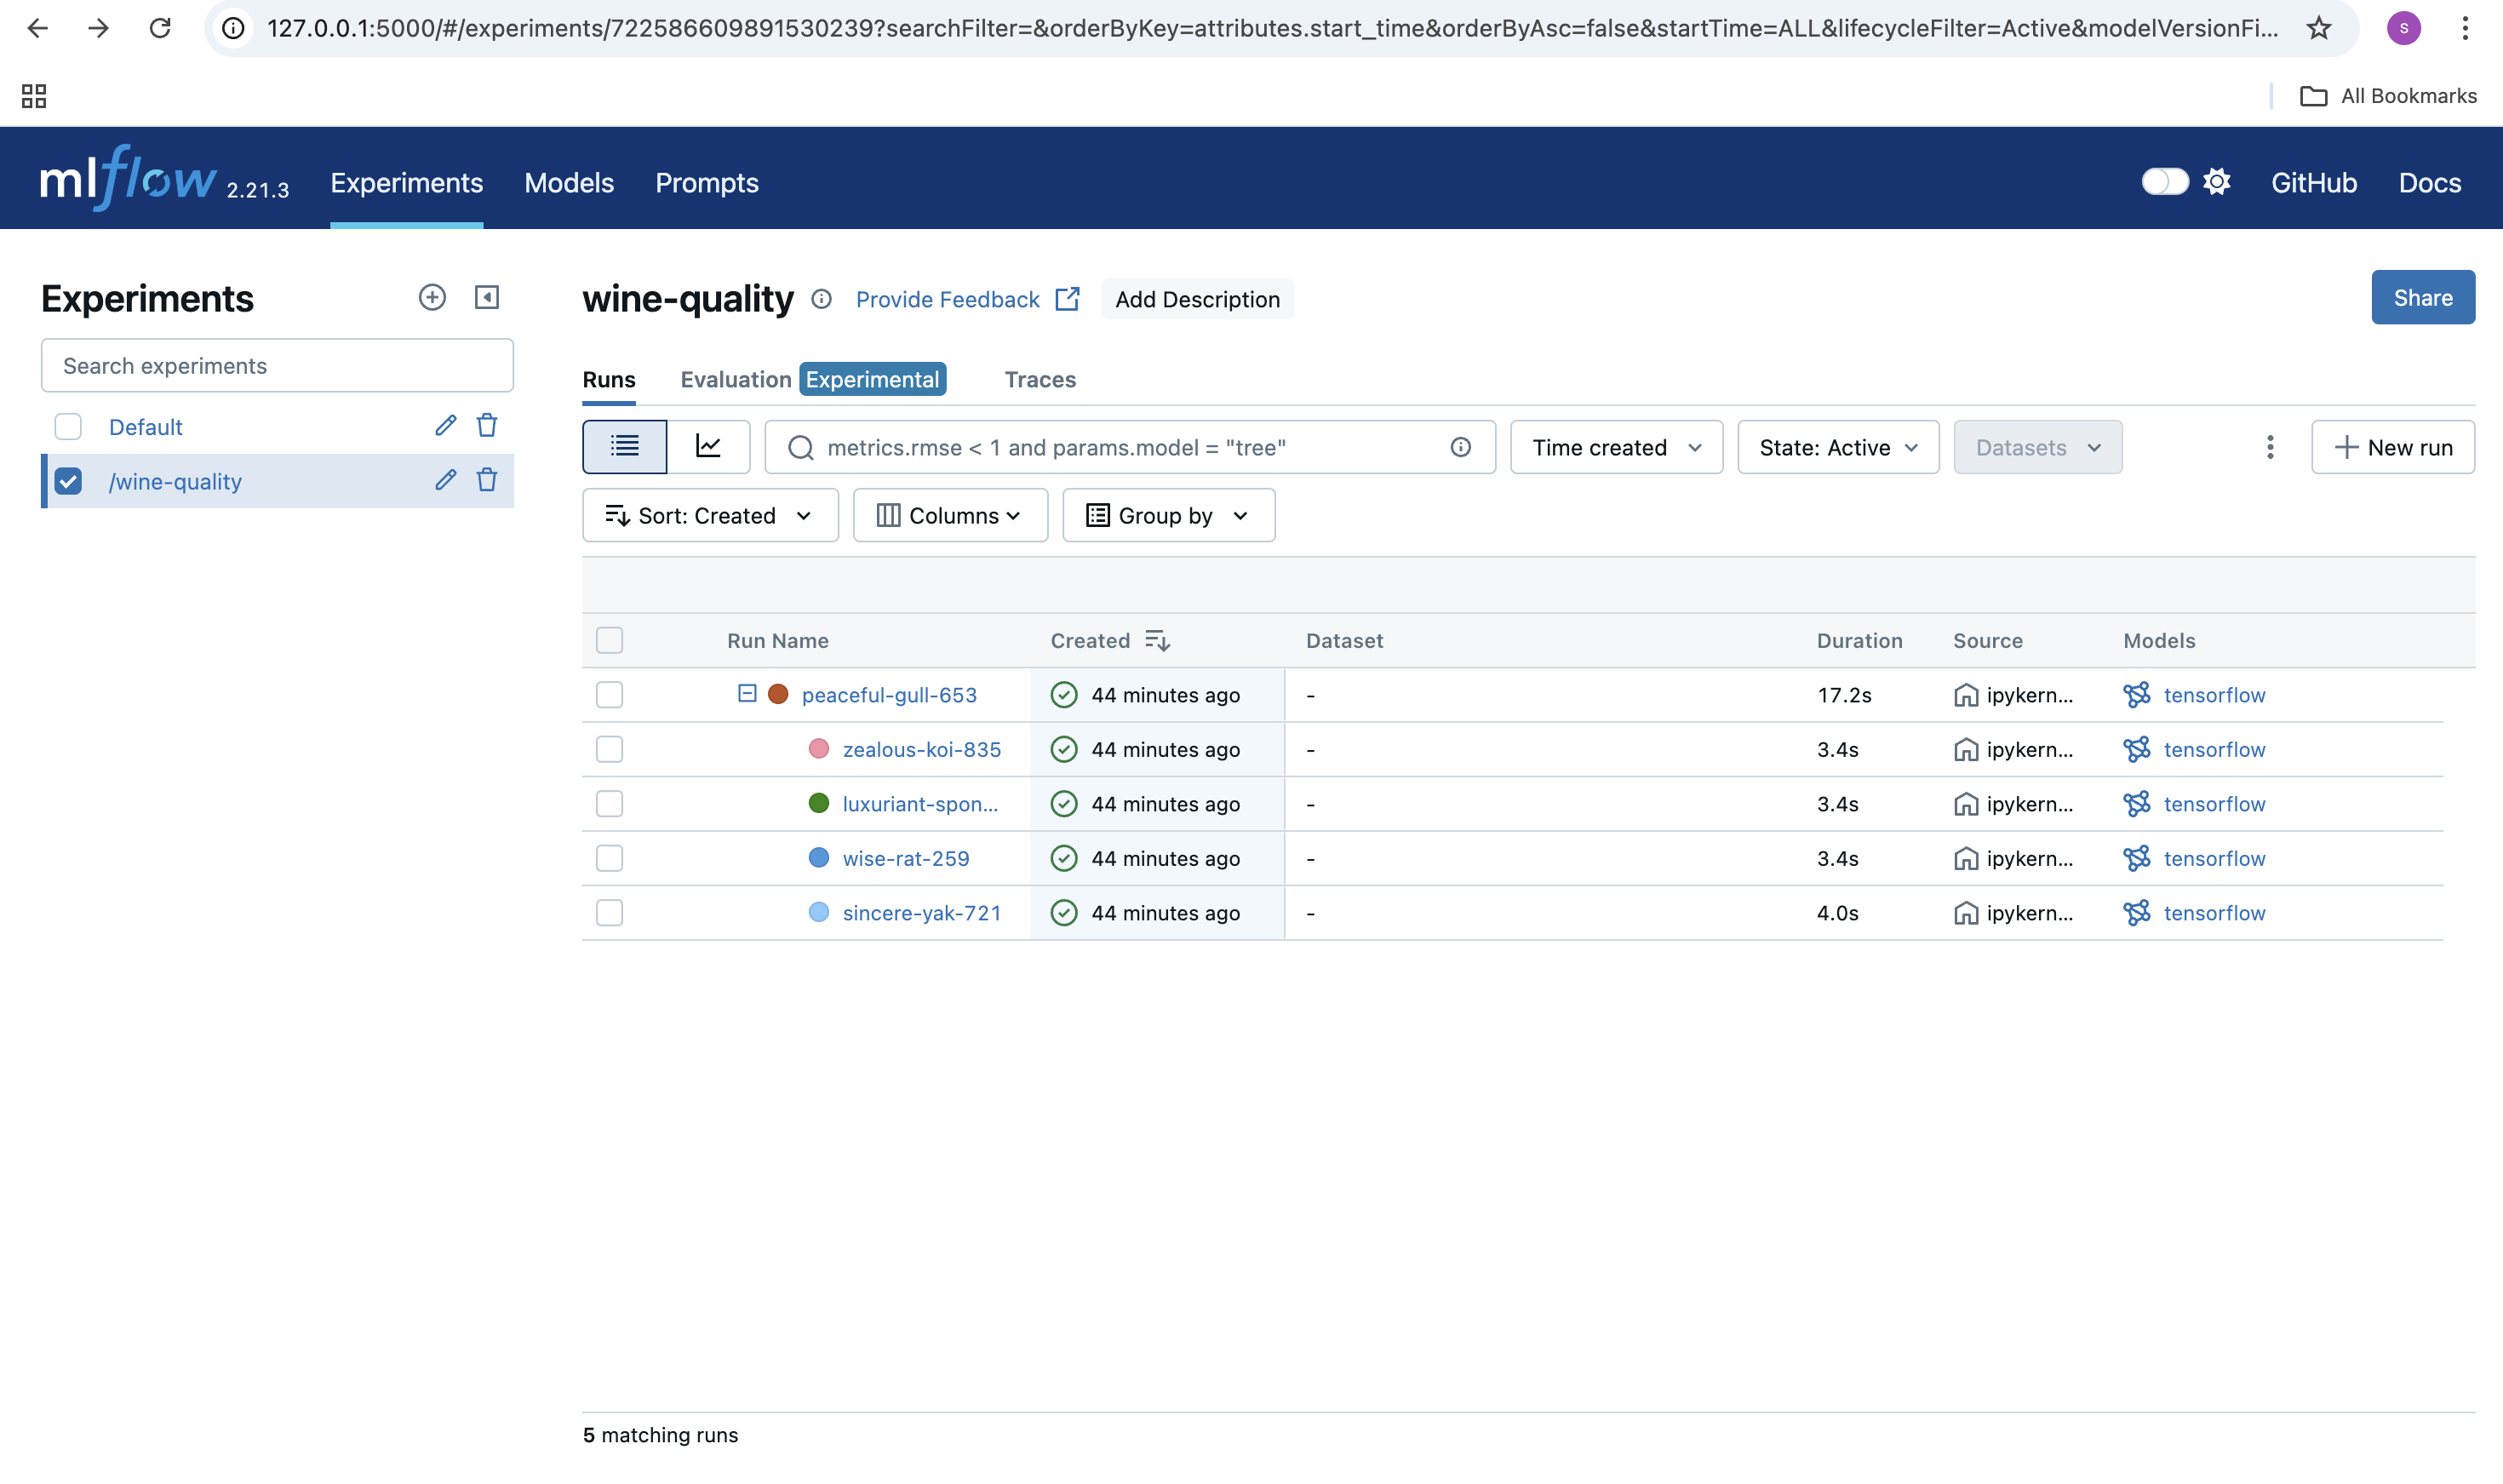

![Screenshot 2025-04-28 at 6.14.13 PM.png](<attachment:Screenshot 2025-04-28 at 6.14.13 PM.png>)
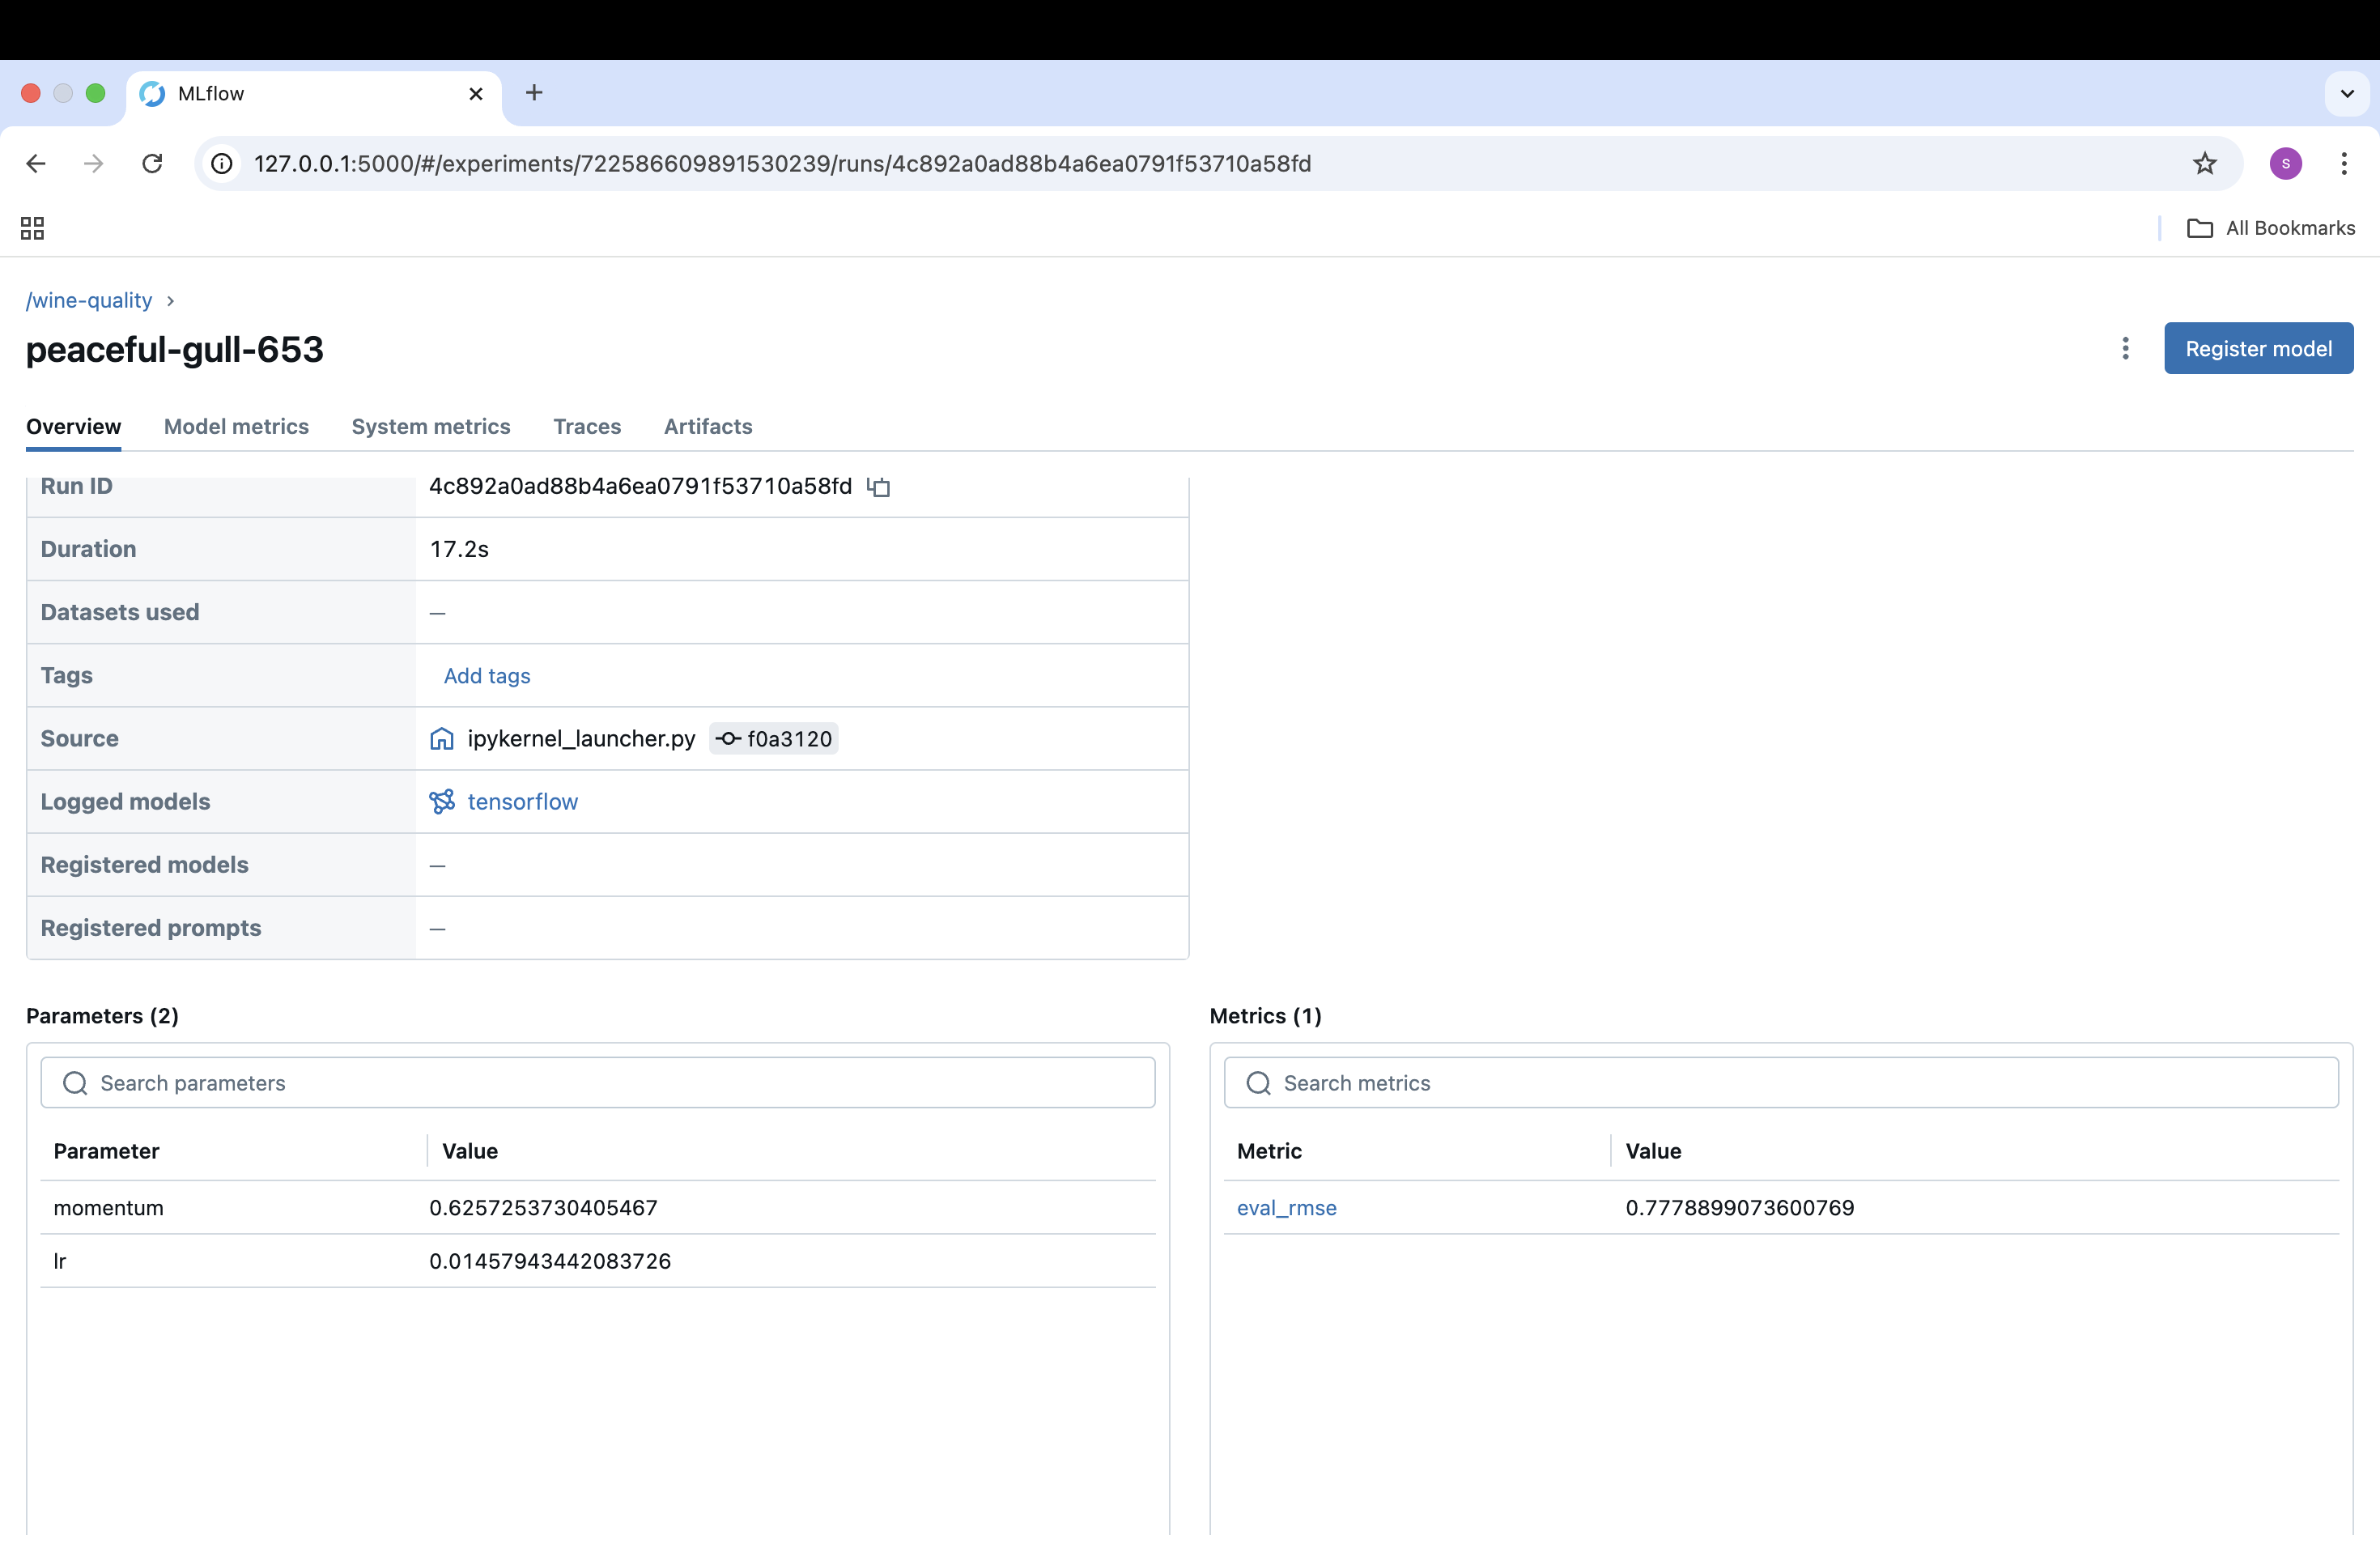

![Screenshot 2025-04-28 at 6.14.30 PM.png](<attachment:Screenshot 2025-04-28 at 6.14.30 PM.png>)
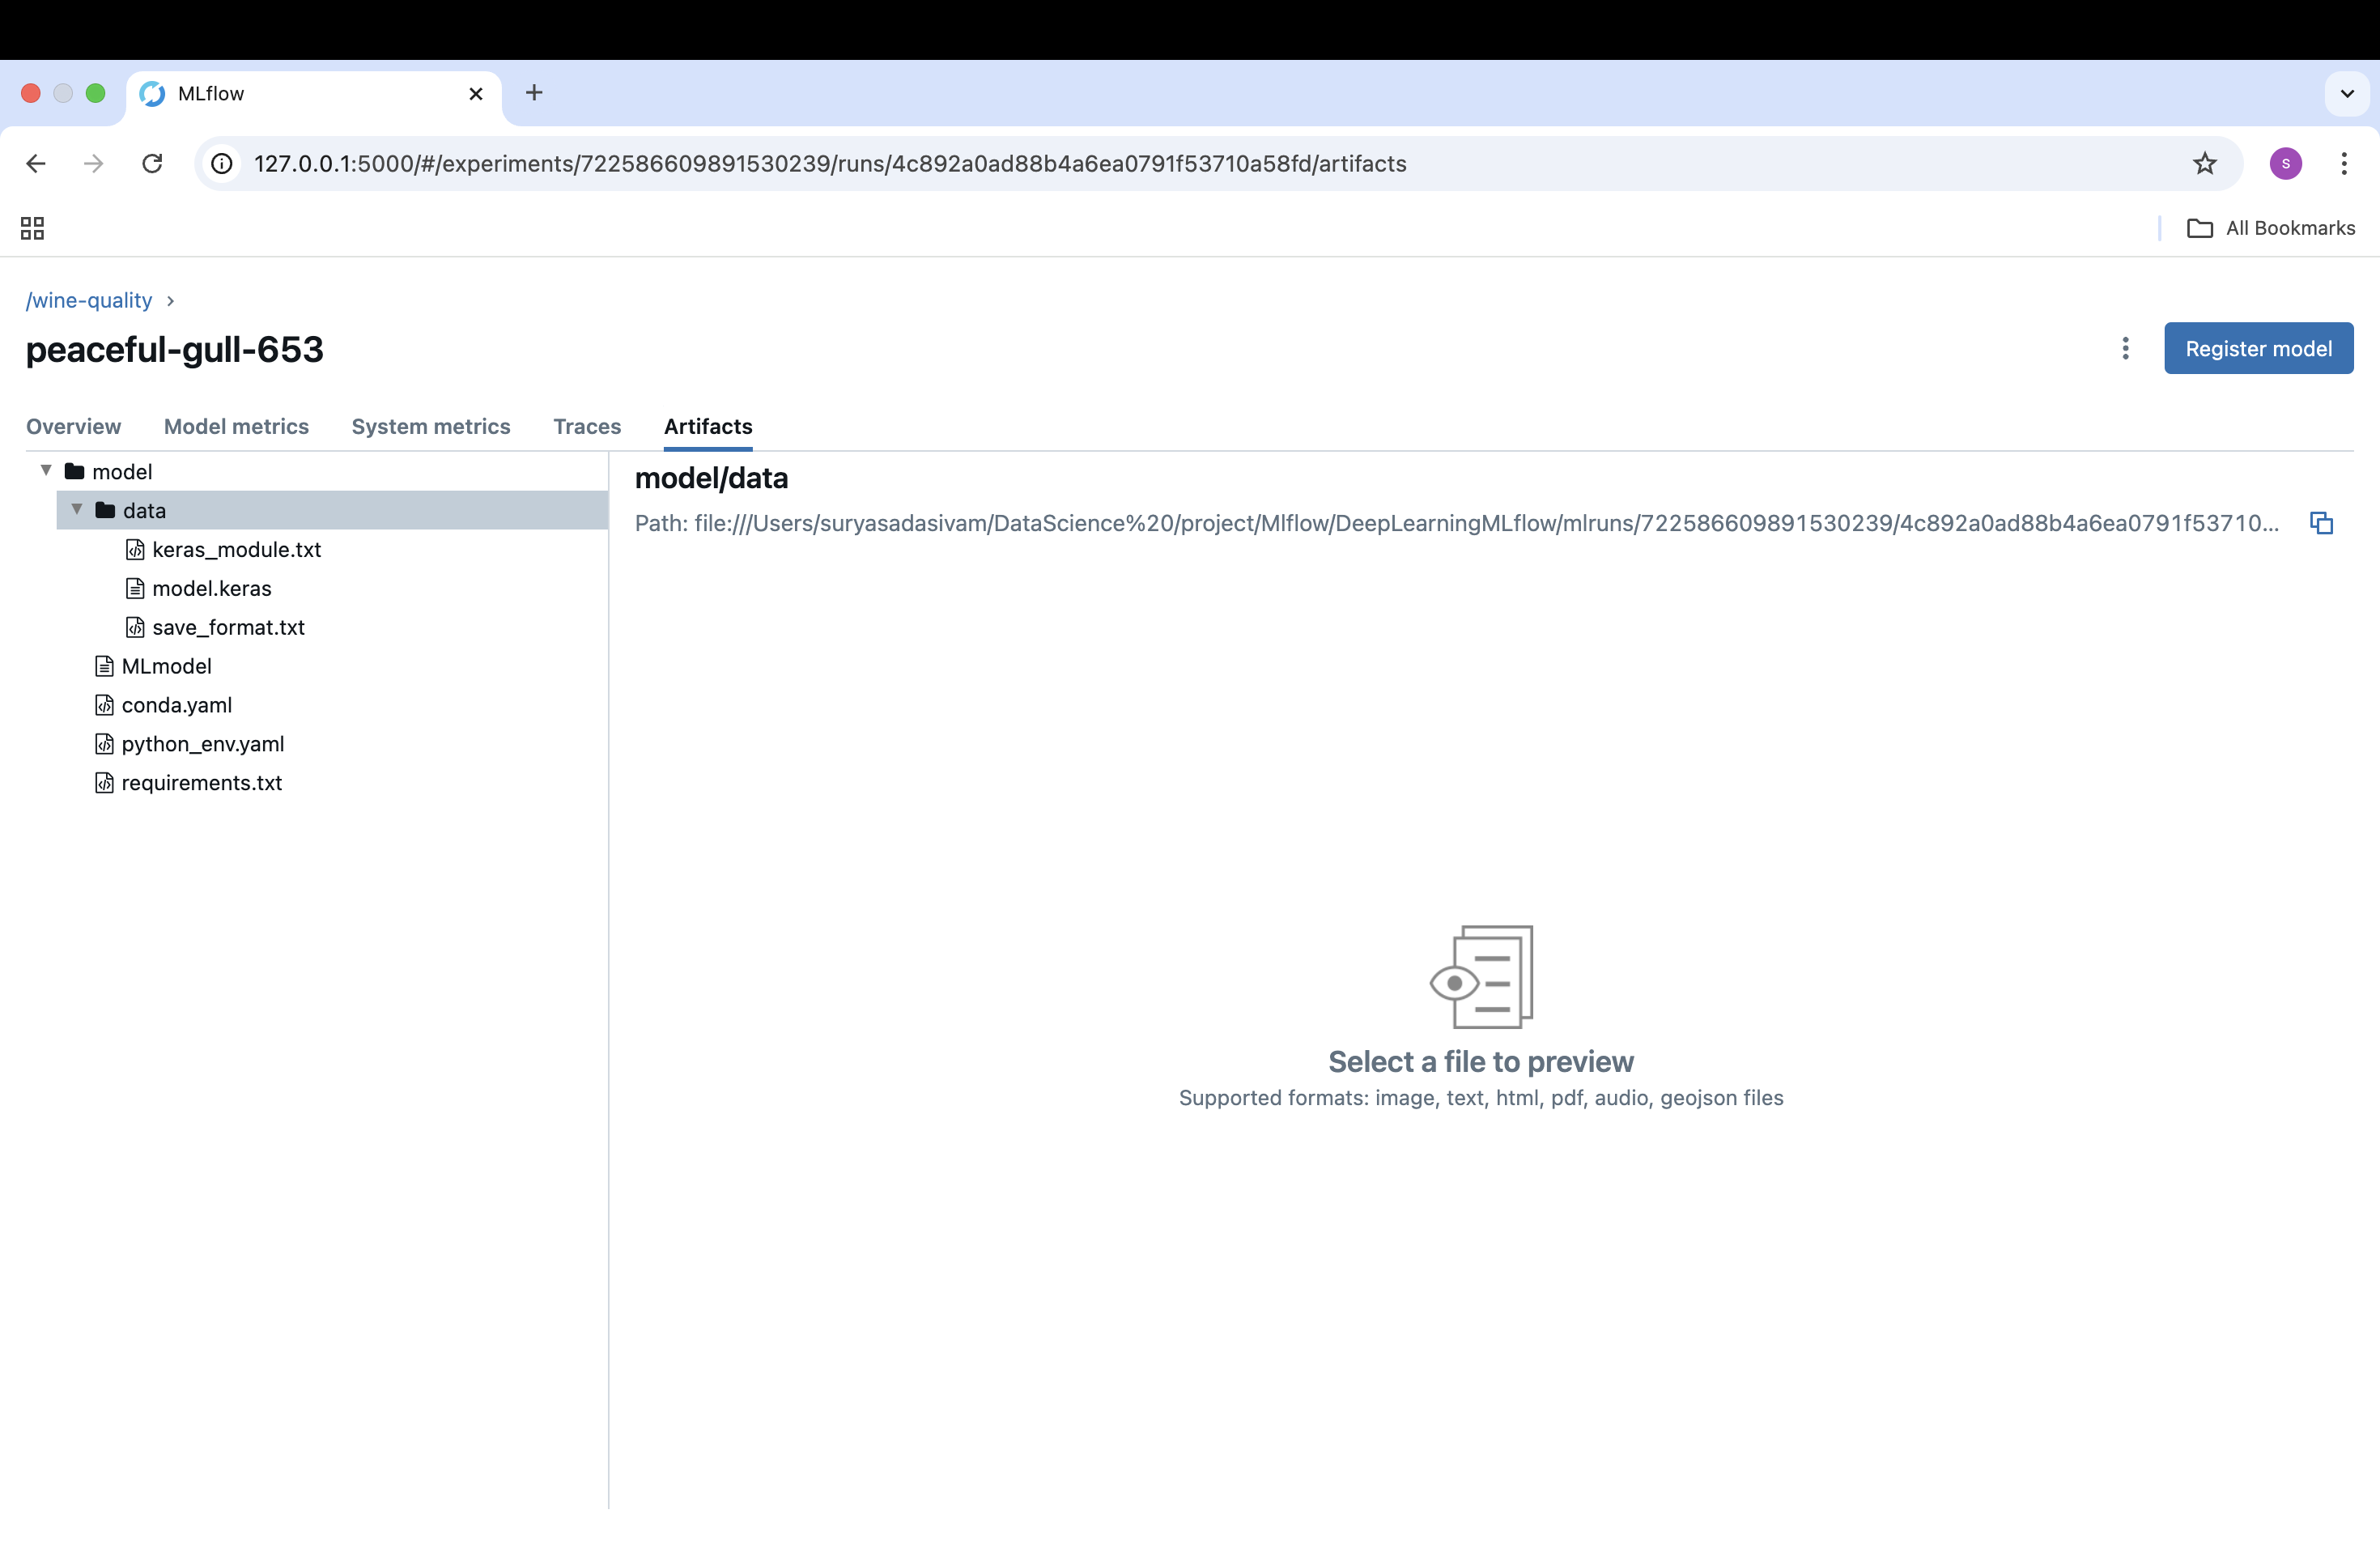

![Screenshot 2025-04-28 at 6.15.16 PM.png](<attachment:Screenshot 2025-04-28 at 6.15.16 PM.png>)
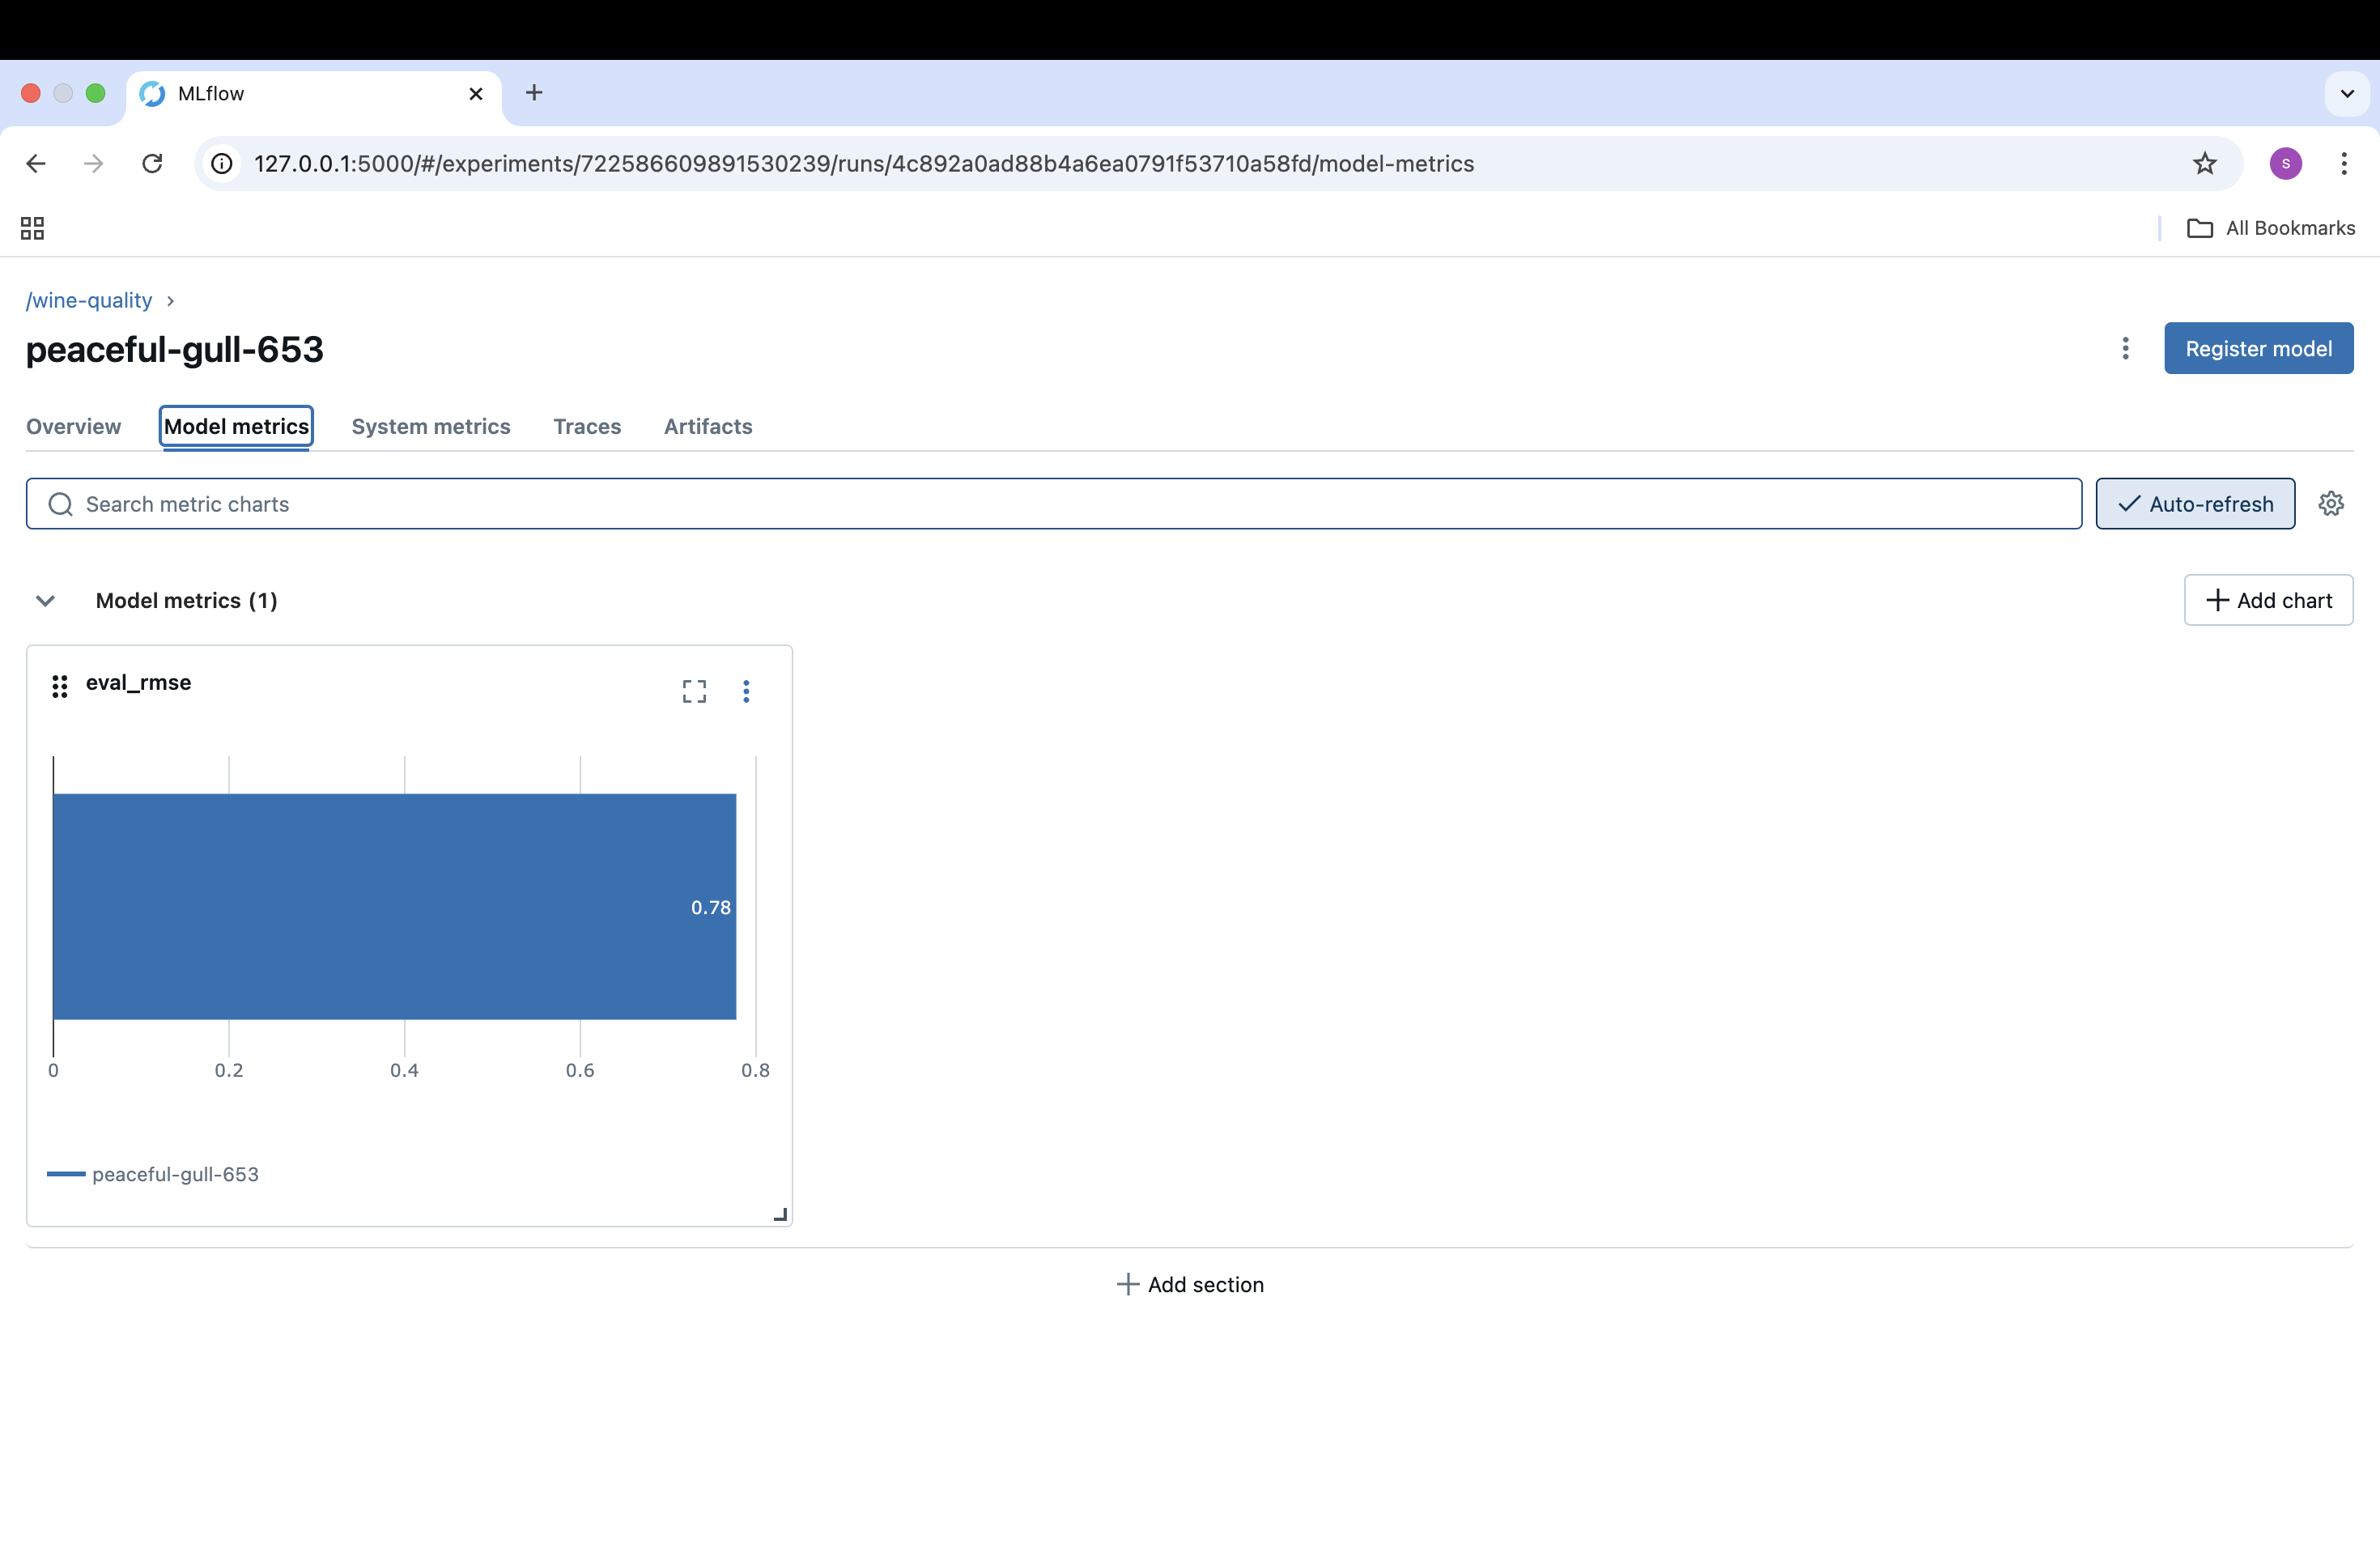

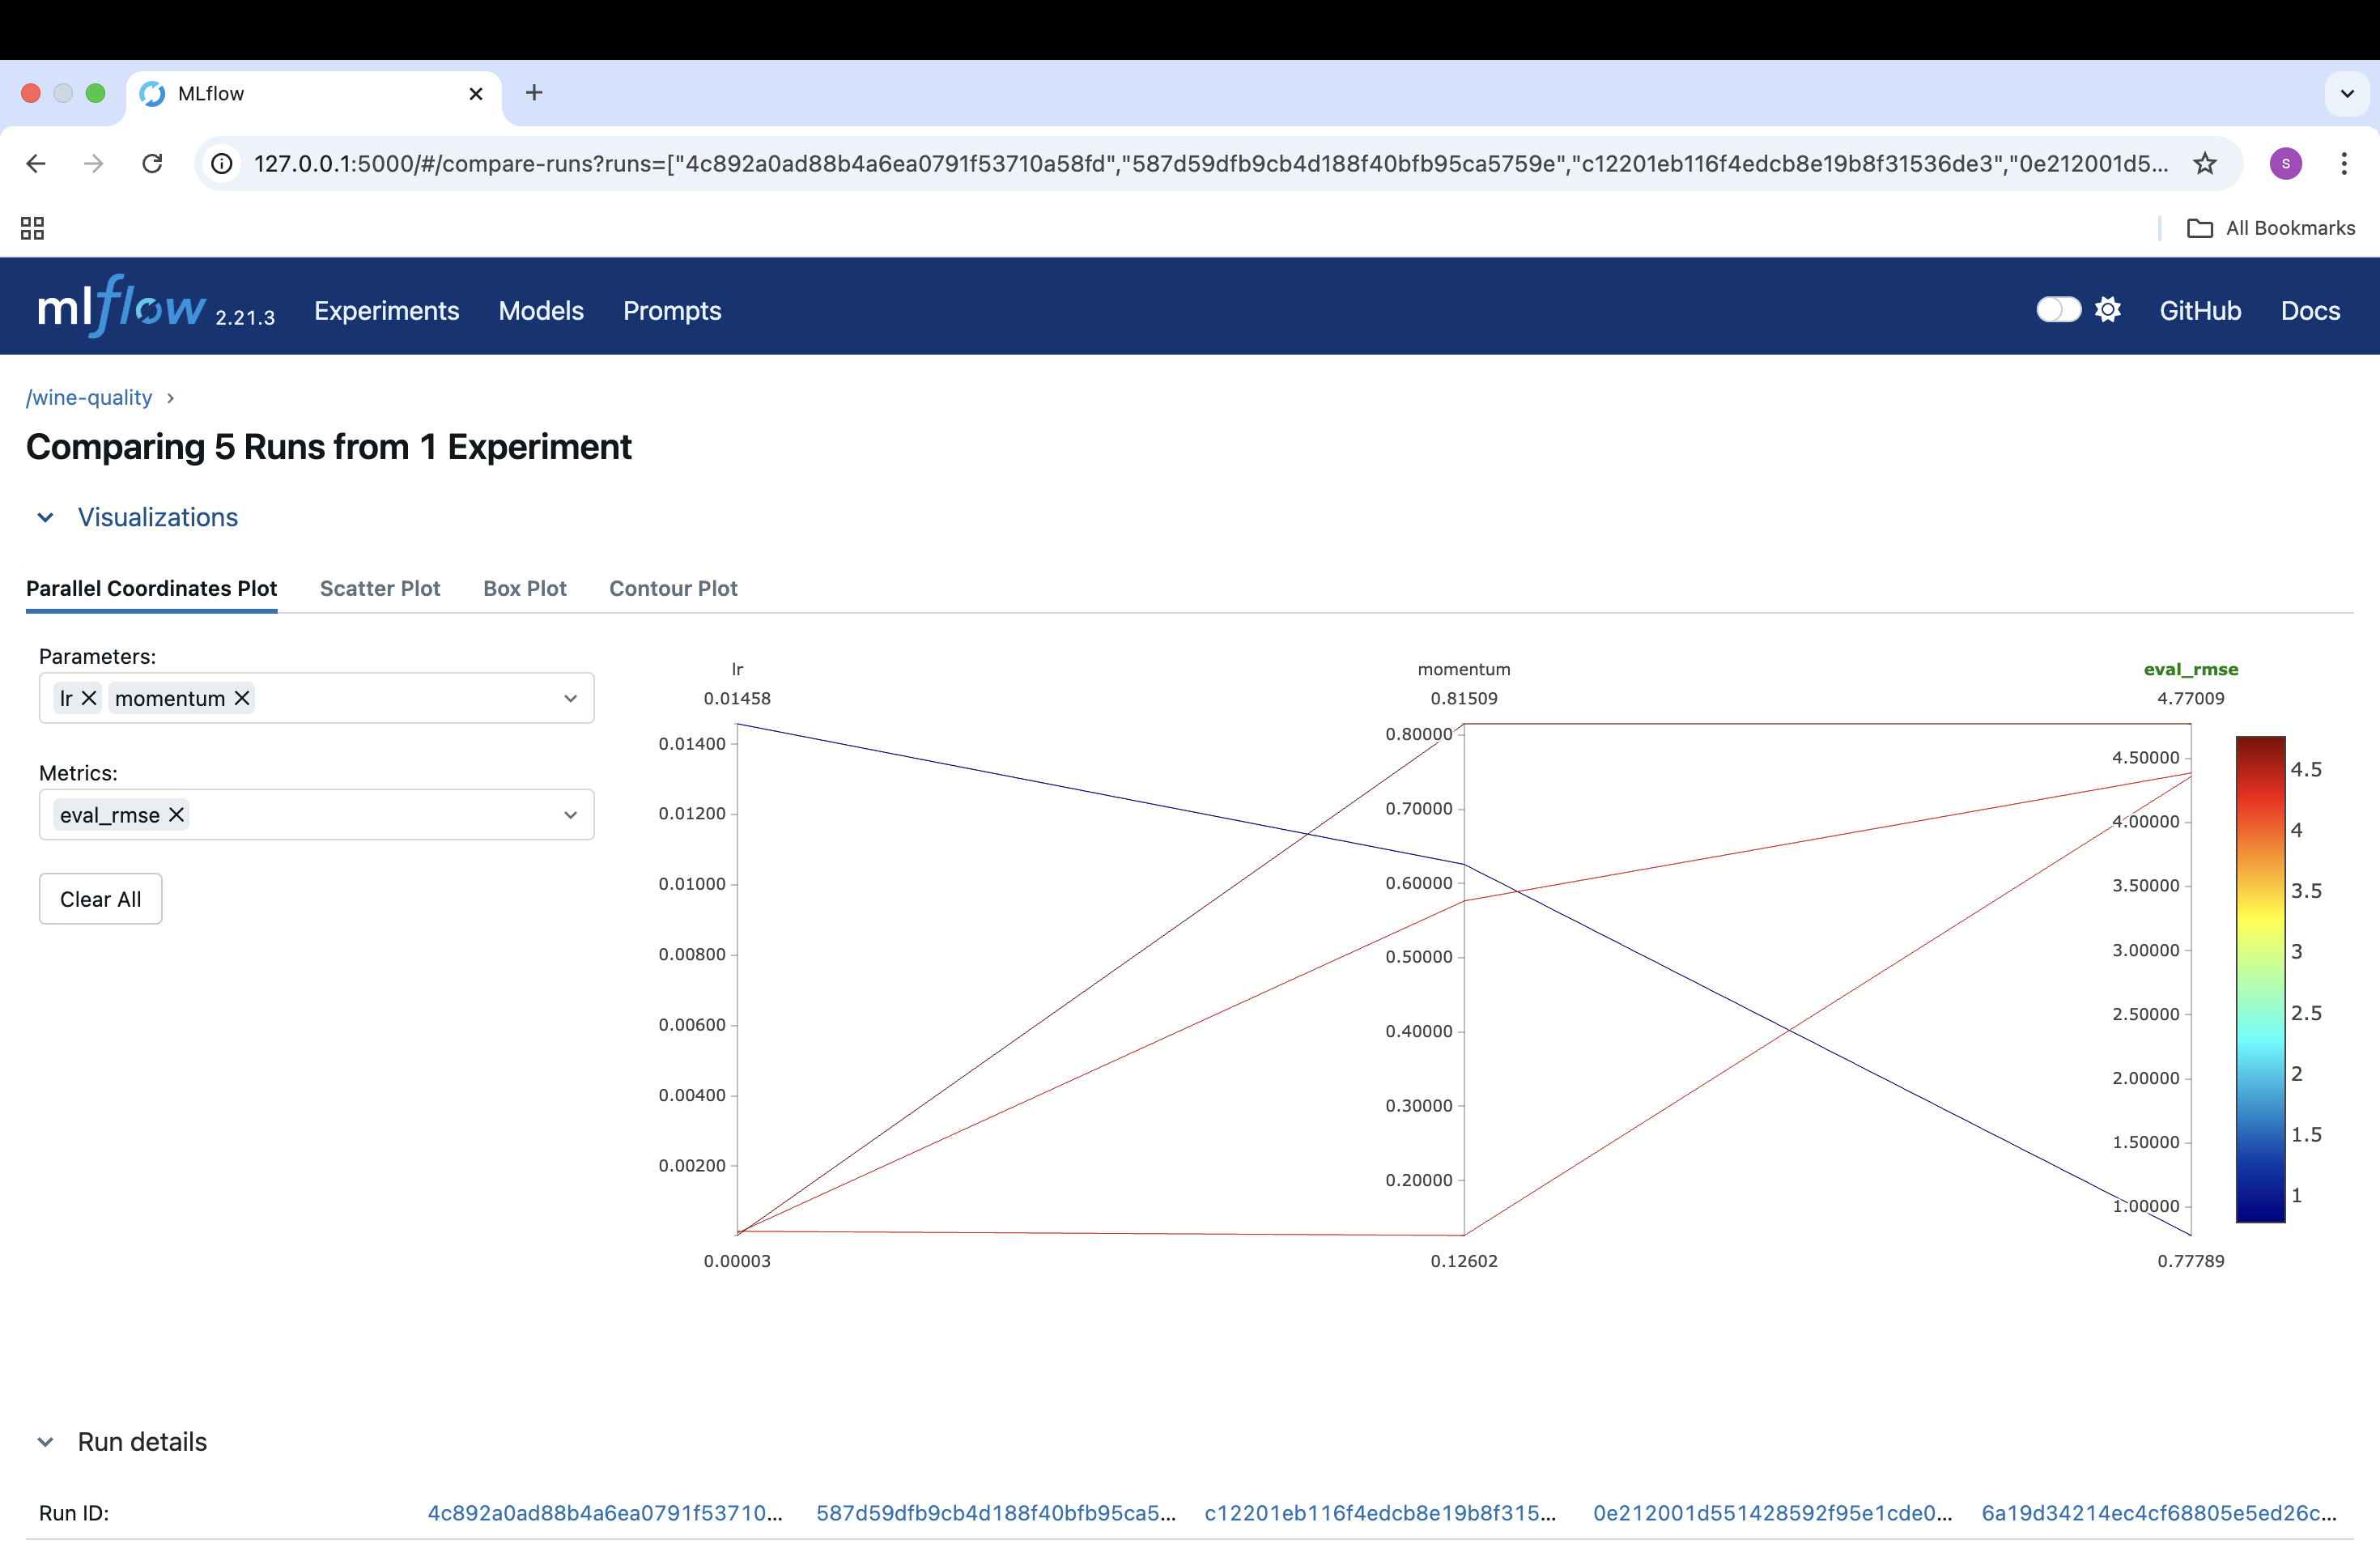

![Screenshot 2025-04-28 at 6.15.42 PM.png](<attachment:Screenshot 2025-04-28 at 6.15.42 PM.png>)
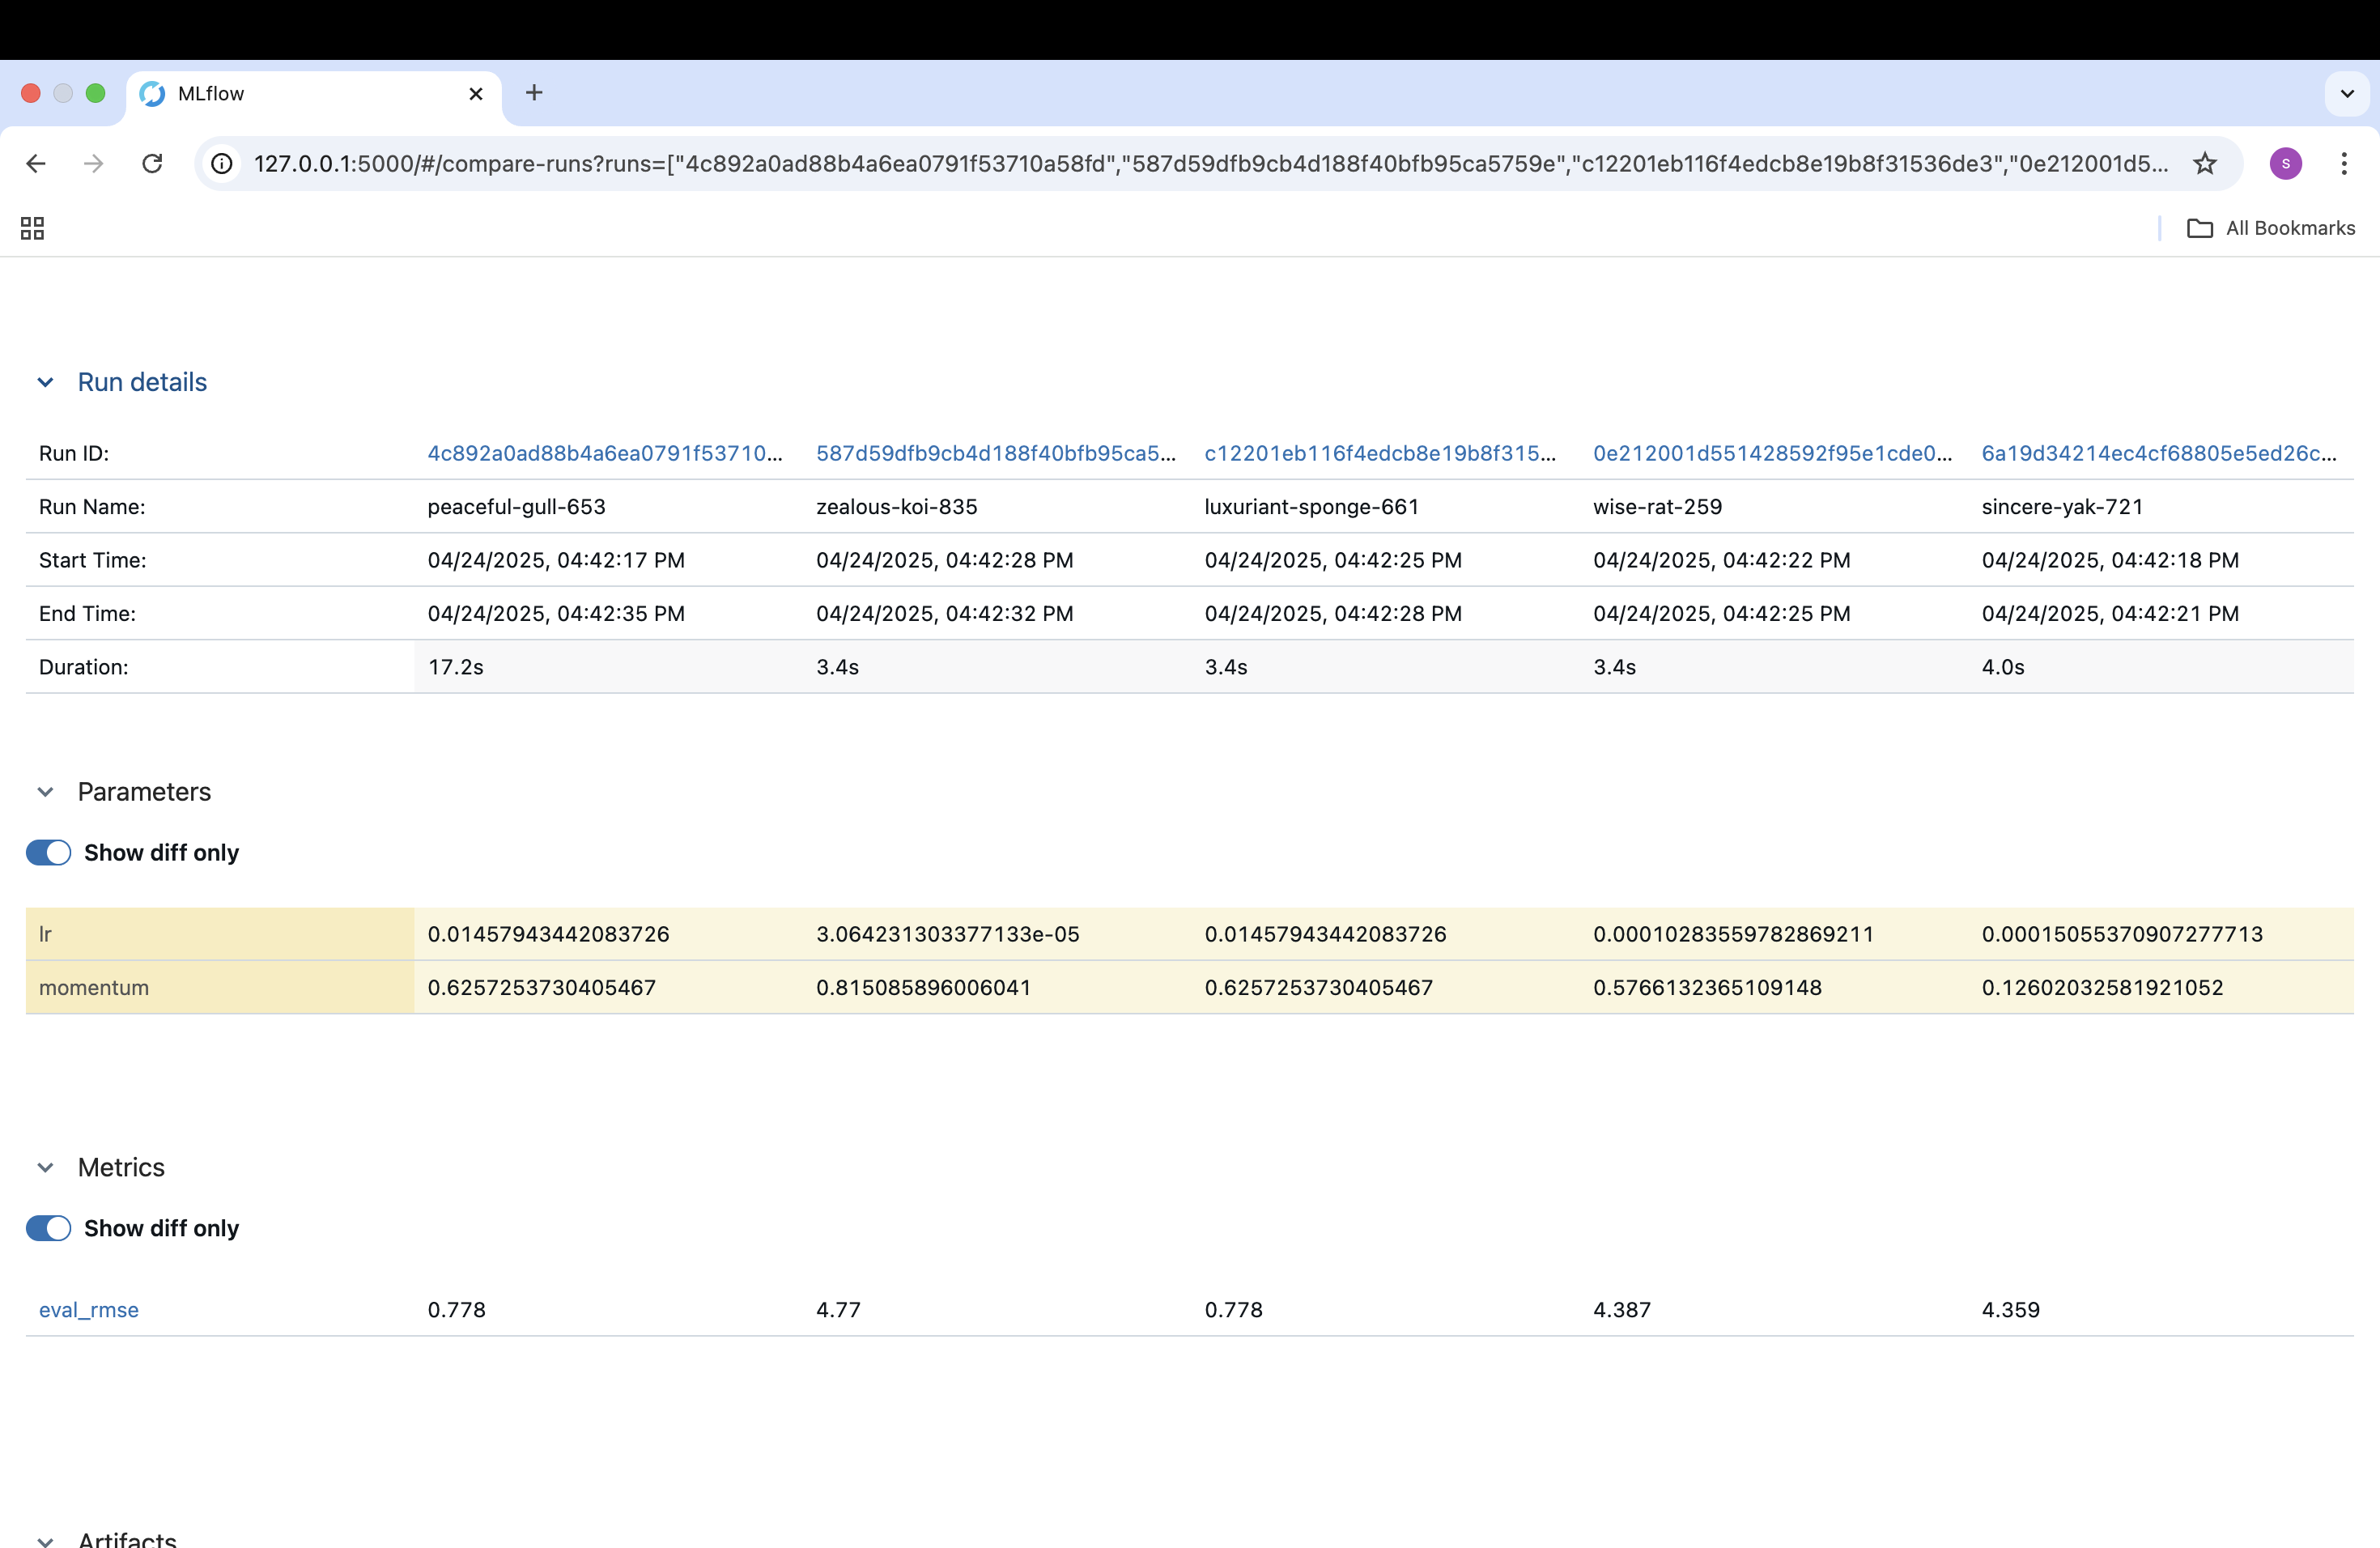